In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='1d485f99-a408-4036-822f-51a27cabe216', project_access_token='p-6f0cc1d9dd927f0a49a40e5c22bdd1415a3277ac')
pc = project.project_context

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

import matplotlib.pyplot as plt

from matplotlib import path

In [3]:
USE_WATSON_STUDIO = True

def read_crimefile(filename):
    if USE_WATSON_STUDIO:
        data = json.load(project.get_file(filename))
    else:
        with open(filename, "r") as read_file:
            data = json.load(read_file)

    for region in data:
        region['dfcrimes'] = pd.read_json(region['dfcrimes'])
        
    return data

In [4]:
def Haversine(lat1,lon1,lat2,lon2, **kwarg):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

In [5]:
def newpointfromdistanceandbearing(lat,lon,distance, bearing):
    """
    φ2 = asin( sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
    λ2 = λ1 + atan2( sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2 )   
    where φ is latitude, λ is longitude, θ is the bearing (clockwise from north), δ is the angular distance d/R;
    d being the distance travelled, R the earth’s radius
    """
    R = 6371.0088
    angdist = distance/R
    lat1,lon1,bearing = map(np.radians, [lat,lon,bearing])
    latnew = math.asin(np.sin(lat1)*np.cos(angdist)+
                       np.cos(lat1)*np.sin(angdist)*np.cos(bearing))
    lonnew = lon1+ math.atan2(math.sin(bearing)*math.sin(angdist)*math.cos(lat1),math.cos(angdist)-math.sin(lat1)*math.sin(latnew))
    lat2,lon2 = map(np.degrees,[latnew,lonnew])
    return lat2,lon2

In [6]:
regions = read_crimefile("regions.json")

In [7]:
def get_crimes(df,lat,lon,search_radius):
    # apply filter first
    c = df.index[df.apply(lambda x: 1000.0*Haversine(lat,lon,x.latitude,x.longitude)<= search_radius , axis=1)]
    #print(f"get_crimes:{c}")
    #return df.loc[c].category
    return c
    #if Haversine(lat,lon,crime_lat,crime_lon) <= search_radius:
    #    yield crime_type

def crime_metric(crimes):
    return len(crimes)

In [8]:
######################### 
# GRAB INFO - can delete
#########################

for region in regions:
    print(f"{region['force']}:{region['hood']}")
    print(len(region['dfcrimes']))
    print(region['dfcrimes'].columns)
    

Thames Valley Police:Abbey / Battle
6288
Index(['category', 'context', 'id', 'location', 'location_subtype',
       'location_type', 'month', 'outcome_status', 'persistent_id', 'latitude',
       'longitude'],
      dtype='object')
Thames Valley Police:Oxford Central
5513
Index(['category', 'context', 'id', 'location', 'location_subtype',
       'location_type', 'month', 'outcome_status', 'persistent_id', 'latitude',
       'longitude'],
      dtype='object')


In [9]:
# work out x and y in terms of metres per crime location with respect to the lower left 'sw' vertex of the bounding box
L1_distance = lambda x,y : math.abs(x)+math.abs(y) 
L2_distance = lambda x,y : math.sqrt(x*x + y*y) 


cell_size = 100.0

for region in regions:

    dfcrimes = region['dfcrimes']
    df_ll = dfcrimes[['latitude','longitude']]
    #df_ll.sample(10)
    bbox = region['bbox']
    bbox_origin = bbox['sw']
    df_ll['x'] = df_ll.apply(lambda x: 1000.0*Haversine(bbox_origin[0],bbox_origin[1],x.latitude,bbox_origin[1]),axis=1)
    df_ll['y'] = df_ll.apply(lambda x: 1000.0*Haversine(bbox_origin[0],bbox_origin[1],bbox_origin[0],x.longitude),axis=1)

    nlat = int(round(1000*Haversine(bbox['sw'][0],bbox['sw'][1],bbox['ne'][0],bbox['sw'][1])/cell_size,0))
    nlon = int(round(1000*Haversine(bbox['sw'][0],bbox['sw'][1],bbox['sw'][0],bbox['ne'][1])/cell_size,0))
    dlat = newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,0)[0]-bbox['sw'][0]
    dlon = newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,90)[1]-bbox['sw'][1]

    print('..crime points..done')

    cell_x = [x*cell_size for x in range(nlat)]
    cell_y = [y*cell_size for y in range(nlon)]

    crimes = np.zeros((nlat,nlon))

    distance = L2_distance


    nx = 0
    for x in cell_x:
        ny = 0
        for y in cell_y:
            dfs = df_ll[(df_ll.x >= x-cell_size) & (df_ll.x <= x+cell_size)]
            dfs = dfs[(dfs.y >= y-cell_size) & (dfs.y <= y+cell_size)]
            c = dfs.apply(lambda row: distance(row.x - x, row.y - y), axis = 1)
            crimes[nx,ny] = len(c)
            ny += 1
        nx += 1

    region['crimes'] = crimes
#calc L2


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


..crime points..done
..crime points..done


In [10]:
'''
idx = 5
x = cell_x[idx]
y = cell_y[idx]

lat = bbox['sw'][0]+dlat*idx
lon = bbox['sw'][1]+dlon*idx
#51.45491695277964,-1.000995553127764 => 245
print(x,y, lat, lon)
search_radius = 300
print(f"x from {x-search_radius} to {x+search_radius}")
print(f"y from {y-search_radius} to {y+search_radius}")
dfs = df_ll[(df_ll.x >= x-search_radius) & (df_ll.x <= x+search_radius)]
dfs = dfs[(dfs.y >= y-search_radius) & (dfs.y <= y+search_radius)]
c = dfs.apply(lambda row : L2_distance(row.x-x,row.y-y) <= search_radius , axis=1)
print(len(dfs),len(c),len(dfs[c]))
'''

'\nidx = 5\nx = cell_x[idx]\ny = cell_y[idx]\n\nlat = bbox[\'sw\'][0]+dlat*idx\nlon = bbox[\'sw\'][1]+dlon*idx\n#51.45491695277964,-1.000995553127764 => 245\nprint(x,y, lat, lon)\nsearch_radius = 300\nprint(f"x from {x-search_radius} to {x+search_radius}")\nprint(f"y from {y-search_radius} to {y+search_radius}")\ndfs = df_ll[(df_ll.x >= x-search_radius) & (df_ll.x <= x+search_radius)]\ndfs = dfs[(dfs.y >= y-search_radius) & (dfs.y <= y+search_radius)]\nc = dfs.apply(lambda row : L2_distance(row.x-x,row.y-y) <= search_radius , axis=1)\nprint(len(dfs),len(c),len(dfs[c]))\n'

In [11]:
'''
cell_size = 100 # metres

# gridify the region as defined by the boundary
region = regions[0]
# Step 1: get the region's bounding box
bbox = region['bbox']
# Step 2: create square cells each of side x metres, e.g. 100m.
# Step 3: discard those cells not inside the boundary
nlat = int(round(1000*Haversine(bbox['sw'][0],bbox['sw'][1],bbox['ne'][0],bbox['sw'][1])/cell_size,0))
nlon = int(round(1000*Haversine(bbox['sw'][0],bbox['sw'][1],bbox['sw'][0],bbox['ne'][1])/cell_size,0))
dlat = newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,0)[0]-bbox['sw'][0]
dlon = newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,90)[1]-bbox['sw'][1]
nlat,nlon,dlat,dlon,bbox['sw'],newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,90)

crimes = np.zeros((nlat,nlon))
cell_lat = [bbox['sw'][0]+x*dlat for x in range(nlat)]
cell_lon = [bbox['sw'][1]+y*dlon for y in range(nlon)]
crimes.fill( -1 )
crime_radius = 300
# get numbers of crimes for each cell using a radius 

dfcrimes = region['dfcrimes']
nx, ny = 0,0
print(f"nlat={nlat},nlon={nlon},dlat={dlat},dlon={dlon}")
for lat in cell_lat:
    ny = 0
    #print(f"{nx}",end='.')
    for lon in cell_lon:
        #c = get_crimes(dfcrimes,lat,lon,crime_radius)
        #crimes[nx,ny] = len(c)
        crimes[nx,ny] = 0
        #print("{0:03d}".format(int(crimes[nx,ny])),end='.')
        if (nx==5) & (ny==5):
            #print()
            c = get_crimes(dfcrimes,lat,lon,crime_radius)
            crimes[nx,ny] = len(c)
            print(f"{lat},{lon},{crimes[nx,ny]}, {len(c)},{c}")
        #print(f"{crimes[nx,ny]}, {len(c)},{c}")
        #crimes[nx,ny] = crime_metric(c)        
        #print(f"{lat},{lon},{c},{crimes[nx,ny]},{crime_radius}")
        
        ny += 1
    #print()
    nx += 1
        #print(lat,lon,crime_metric(c))
#for x in range(nlat):
#    for y in range(nlon):        
#        #crimes_box = dfcrimes[dfcrimes.latitude]
#        crimes[x,y] = x+y

#crimes
print("...done...")
'''

'\ncell_size = 100 # metres\n\n# gridify the region as defined by the boundary\nregion = regions[0]\n# Step 1: get the region\'s bounding box\nbbox = region[\'bbox\']\n# Step 2: create square cells each of side x metres, e.g. 100m.\n# Step 3: discard those cells not inside the boundary\nnlat = int(round(1000*Haversine(bbox[\'sw\'][0],bbox[\'sw\'][1],bbox[\'ne\'][0],bbox[\'sw\'][1])/cell_size,0))\nnlon = int(round(1000*Haversine(bbox[\'sw\'][0],bbox[\'sw\'][1],bbox[\'sw\'][0],bbox[\'ne\'][1])/cell_size,0))\ndlat = newpointfromdistanceandbearing(bbox[\'sw\'][0],bbox[\'sw\'][1],cell_size/1000,0)[0]-bbox[\'sw\'][0]\ndlon = newpointfromdistanceandbearing(bbox[\'sw\'][0],bbox[\'sw\'][1],cell_size/1000,90)[1]-bbox[\'sw\'][1]\nnlat,nlon,dlat,dlon,bbox[\'sw\'],newpointfromdistanceandbearing(bbox[\'sw\'][0],bbox[\'sw\'][1],cell_size/1000,90)\n\ncrimes = np.zeros((nlat,nlon))\ncell_lat = [bbox[\'sw\'][0]+x*dlat for x in range(nlat)]\ncell_lon = [bbox[\'sw\'][1]+y*dlon for y in range(nlon)]\ncrime

In [12]:
'''
region = regions[0]
dfcrimes = region['dfcrimes']
df = dfcrimes
#c = get_crimes(dfcrimes,lat,lon,crime_radius/1000.0)
lat = cell_lat[0]
lon = cell_lon[0]
print(f"lat={lat}, lon={lon}")
search_radius = crime_radius
print(search_radius)
c = df.index[df.apply(lambda x: 1000.0*Haversine(lat,lon,x.latitude,x.longitude)<= search_radius , axis=1)]
df.loc[c]
len(c)
'''

'\nregion = regions[0]\ndfcrimes = region[\'dfcrimes\']\ndf = dfcrimes\n#c = get_crimes(dfcrimes,lat,lon,crime_radius/1000.0)\nlat = cell_lat[0]\nlon = cell_lon[0]\nprint(f"lat={lat}, lon={lon}")\nsearch_radius = crime_radius\nprint(search_radius)\nc = df.index[df.apply(lambda x: 1000.0*Haversine(lat,lon,x.latitude,x.longitude)<= search_radius , axis=1)]\ndf.loc[c]\nlen(c)\n'

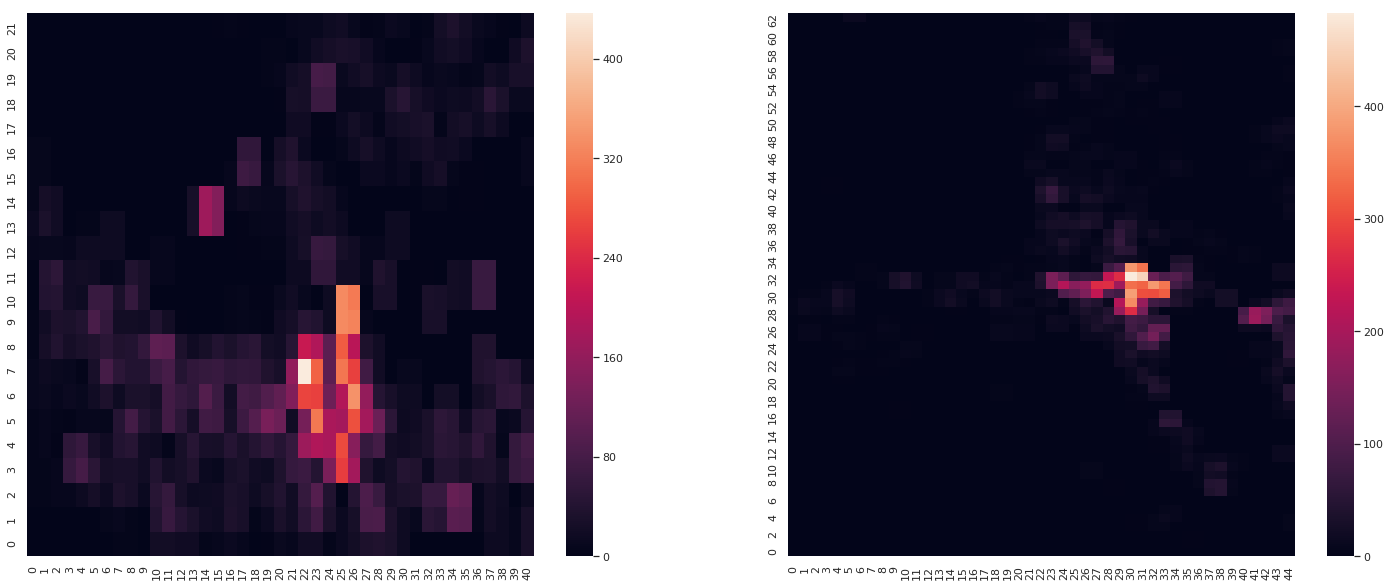

In [21]:
%matplotlib inline

import seaborn as sns; sns.set()

fig, axes = plt.subplots(1, 2, figsize = (25,10))
nax = 0
for region in regions:
    ax = sns.heatmap(region['crimes'], ax = axes[nax])
    nax += 1
    ax.invert_yaxis()
    #project.save_data("filename", )

ax = axes[0]
im = ax.collections[0]
rgba_values = im.cmap(im.norm(im.get_array()))
#extent =axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('ax0_figure.png', bbox_inches=extent)
#plt.matshow(crimes)
#plt.show()

In [25]:
rgba_values = rgba_values.reshape((im._meshHeight, im._meshWidth, 4))


ValueError: Must pass 2-d input

In [15]:
project.save_data("region_0.csv", regions[0]['dfcrimes'].to_csv(), overwrite = True)

{'file_name': 'region_0.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneweek2-donotdelete-pr-kjkdohfctyiyg9',
 'asset_id': 'dfc2360c-14db-4499-a561-2b712d0e6341'}

In [27]:
# Get HOT SPOTS

nreg = 0
for region in regions:
    ncrimes = region['crimes']
    project.save_data(f"region_{nreg}.csv", region['crimes'], overwrite = True)
    nreg += 1
    # make map
    # iterate through points creating rectangle
    # colour 

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: [[  0.   0.   0.   1.   1.   0.   1.   5.   4.   0.  21.  21.  18.  18.
    4.   8.  12.   8.   0.   3.  11.   8.  19.  20.   5.  13.  22.  34.
   37.  32.  16.   0.   0.   0.   0.   0.   0.  15.  15.   8.  28.]
 [  0.   0.   0.   1.   1.   0.   6.  10.   4.   0.  38.  64.  44.  32.
   20.  16.  34.  28.   4.  13.  30.  20.  51.  75.  31.  13.  26.  85.
   86.  34.  16.   9.  49.  43. 101.  98.   6.  21.  15.   8.  28.]
 [  4.   4.   8.   8.  15.  24.  14.  33.  28.  12.  46.  60.  26.  14.
   16.  18.  32.  28.  16.  27.  39.  20.  61.  96.  39.   0.  41.  88.
   66.  25.  31.  34.  62.  63. 115. 106.   7.  22.  16.   0.  15.]
 [  4.   4.   8.  62.  79.  49.  24.  28.  28.  20.  39.  22.  27.  36.
   12.  10.  26.  32.  20.  17.  35.  62.  68.  41. 135. 261. 176.  37.
   17.  23.  42.  36.  13.  39.  38.  26.  33.  35.  22.  60.  69.]
 [  4.   7.   3.  54.  64.  28.  18.  40.  46.  20.  16.   5.  27.  46.
   28.  27.  43.  30.  41.  56.  44.  60. 169. 191. 183. 272. 150.  62.
   77.  22.  18.  22.  30.  48.  46.  36.  56.  37.   6.  60.  78.]
 [  4.   8.   4.   3.   7.   7.   6.  43.  78.  44.  31.  76.  51.  25.
   75.  71.  27.  69.  96. 134. 121.  20. 130. 313. 183. 179. 277. 176.
  121.  50.  14.  18.  30.  52.  45.  18.  45.  48.   9.  13.  43.]
 [ 10.  11.   8.  13.  10.  20.  33.  17.  32.  32.  25.  76.  62.  53.
   94.  68.  21.  77.  72.  93. 108. 142. 268. 263. 122. 192. 338. 162.
   44.  28.  17.  17.   0.  23.  23.   0.  21.  30.  53.  57.  34.]
 [ 10.  14.  11.  10.   3.  28.  79.  51.  40.  40.  68.  81.  42.  56.
   61.  64.  53.  57.  56.  37.  29. 159. 437. 292. 103. 311. 263.  74.
   19.   0.  10.  10.   0.   0.   0.   0.  36.  42.  50.  44.  15.]
 [  4.  24.  38.  24.  31.  37.  49.  37.  40.  59. 106. 103.  34.  18.
   26.  40.  32.  43.  48.  23.  20.  45. 215. 190. 103. 287. 199.  34.
   19.   0.   0.   0.   0.   0.   0.   0.  36.  36.   0.   0.   0.]
 [  4.  20.  34.  31.  38.  84.  59.  21.  21.  19.  38.  22.   3.   0.
    0.   0.   5.   6.   4.   3.  18.  25.  46.  39.  16. 331. 323.   8.
    0.   0.   0.   0.  28.  28.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  40.  42.  19.  17.  66.  66.  30.  60.  30.   0.   0.   0.   0.
    0.   0.   5.   6.   3.   2.  11.  20.   9.   0.  16. 331. 315.   0.
   29.  29.   0.   2.  30.  29.  21.  20.  65.  65.   0.   0.   0.]
 [  0.  42.  52.  20.  22.  19.   7.   9.  39.  30.   8.   8.   0.   0.
    0.   0.   0.   0.   0.   0.   0.  15.  15.  55.  55.  20.  20.   8.
   37.  29.   0.   2.   2.   1.  21.  20.  65.  65.   0.   0.   0.]
 [  7.   9.  10.   8.  17.  17.  17.  17.   0.   0.   8.   8.   0.   0.
    0.   0.   0.   3.   3.   4.   4.  17.  26.  64.  61.  26.  20.   8.
    8.  16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 13.  31.  19.   1.   5.   5.  17.  17.   0.   0.   0.   0.   0.  27.
  171. 144.   0.   3.   6.   7.   7.  19.  25.  17.  22.  14.   0.   0.
    0.  16.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  6.  24.  19.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  27.
  171. 144.   7.  15.  11.  10.  10.  26.  36.  27.  22.   8.   0.   0.
    0.   0.   0.   0.   6.   6.   0.   3.   3.   0.   0.   0.   0.]
 [  6.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   7.  71.  64.   7.  32.  45.  33.  19.   6.   0.   0.  12.
   12.   8.  12.   4.  18.  24.   6.   3.   3.   0.   0.   0.  10.]
 [  6.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.  56.  56.   0.  25.  37.  12.   1.   1.   6.  16.  27.
   17.   8.  15.  20.  25.  18.  19.  13.   0.   0.   0.   0.  10.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.  18.  18.   2.   2.  13.  23.  15.
    5.  20.  23.  29.  31.   5.  22.  27.  17.  27.  15.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   3.  27.  24.  67.  67.   7.   7.   9.
    9.  31.  45.  27.  18.  12.  16.  15.  22.  48.  32.  11.  11.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   5.   8.  19.  24.  81.  77.  11.  19.  26.
   14.  11.  25.  17.   7.  11.   9.   4.   6.  21.  17.  29.  29.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   5.   5.   1.  10.  20.  24.  30.  29.  20.
    8.   0.   0.   3.  10.  20.  23.  18.   8.   0.   0.  18.  33.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   3.   4.   2.   1.   0.   1.   8.   9.  10.  17.  19.  10.   3.
    5.  12.  10.   0.   4.  23.  34.  22.  11.   7.   3.   0.  15.]], type: <class 'numpy.ndarray'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [ ]:
# SHOW MAP WITH HOT SPOTS OVERLAY